## Overview
At phase 1, we focus on buliding a DNN model to price a vanilla European put option accurately. In the training section, all the inputs features are simulated randomly to enable the model to capture the right weights for each feature.  In the test case, we evalueated our model performance in two seperate scenarios, random sample and static sample

At phase 2, we calculated the Greeks based on the pricing model, or name it as the 'first' model. Numerical results and DNN model results are both shown in this part.Single output or multi-outputs are also been compared. The conclusions are:
1. Numerical Greeks usually have bumps
2. To smooth the Greeks, both multi-outputs and extended DNN model work well

To be continued:

1. Stability of the pricing( the first) model needs to be tested, in the static test case, we found that the percentage errors are pretty different with varying input range.

2. In my model , I took one feature as the input to the next extened model, even in the multi-output case as the output is the first order and second order differentials. I'd like to know if it's possible to get all Greeks at one model with multiple input features and combined loss functions

## Phase 1

### Part 1: Set up and define Helper functions

In [1]:
import torch
import pandas as pd
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer
from sklearn.metrics import mean_absolute_error,mean_absolute_error
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp,log,sqrt
from scipy import stats
from scipy.stats import norm

### Helper functions

In [51]:
# Black Scholes Put option and Greeks
def bsput(s0,k,t,r,sigma):
    """
    s0: spot price
    k: strike
    t: T-t maturity
    r: risk free rate
    sigma: volatility
    y: dividend yield ==0
    """
    d1=(log(s0/k)+(r+sigma**2/2)*t)/(sigma*sqrt(t))
    d2=d1-sigma*sqrt(t)    
    return -s0*norm.cdf(-d1)+k*exp(-r*t)*norm.cdf(-d2),s0*norm.pdf(d1)*t**0.5 

def closedform_Euro(row):
    return bsput(row['S'],row['K'],row['T'],row['rf'],row['Vol'])

cdf = torch.distributions.Normal(0,1).cdf
pdf = lambda x: torch.distributions.Normal(0,1).log_prob(x).exp()


def bs_greeks(s0,k,t,r,sigma):
    d1=(log(s0/k)+(r+sigma**2/2)*t)/(sigma*sqrt(t))
    d2=d1-sigma*sqrt(t)
    delta=-norm.cdf(-d1)
    gamma=norm.pdf(d1)/s0/sigma/np.sqrt(t)
    theta=-s0*sigma/2/np.sqrt(t) *norm.pdf(d1)+r*k*exp(-r*t)*norm.cdf(-d2)
    return delta,gamma,theta

def closedform_greeks(row):
    return bs_greeks(row['S'],row['K'],row['T'],row['rf'],row['Vol'])

def numerical_greeks(df_test):
    """
    Input Dataframe:
    S: spot price
    Put_nn: estimated values from model
    Delta: closed form
    Gamma: closed form
    """
    diff=df_test[['S','Put_nn']].sort_values('S').diff(1).dropna().reset_index(drop=True)
    diff['Delta_c']=diff['Put_nn']/diff['S']
    diff['Gamma']=diff['Delta_c'].diff(1)/diff['S'].shift(1)
    
    # Numerical & closed form Delta plot
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(10,6))
    plt.scatter(df_test.sort_values('S')['S'][:-1],diff['Delta_c'].values, color='orange')
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.scatter(df_test['S'],df_test['Delta'].values)
    plt.show()
    
    # Numerical & closed form Gamma plot
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(10,6))
    plt.scatter(df_test.sort_values('S')['S'][:-1],diff['Gamma'].values, color='orange')
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.scatter(df_test['S'],df_test['Gamma'].values)
    plt.show()

### Part2: Data preparation

#### data generator: random_generator, mesh_generator, static_test_generator

In [52]:
def generate_random_train_data(n=250000, corner=False):
    df=pd.DataFrame({"S":np.ones(n),
                     "K":np.random.uniform(low=0.5,high=1.5,size=n),
                     "Vol":np.random.uniform(low=0.1,high=0.4,size=n),
              "T":np.random.uniform(low=0.25,high=2,size=n),
                     "rf":np.random.uniform(low=0.0025,high=0.025,size=n)})
    
    if corner:
        df_corner=pd.DataFrame({"S":np.ones(n),
                         "Vol":np.ones(n)*0.2,
                         "T":np.ones(n),
                         "rf":np.ones(n)*0.01})

        df_corner['K']=df_corner['S']*np.random.uniform(low=0.8,high=0.95,size=n) # special region
        df = df.append(df_corner)

    df[["Put","Vega"]]=df.apply(closedform_Euro, axis=1, result_type="expand")

    # weighted by T
    df["Put"] = df["Put"]/df["K"]/np.sqrt(df['T'])
    df['K']=df['K']/np.sqrt(df['T'])
    
    return df

In [53]:
# 50 * 30 * 7 * 10 = 105K
def generate_mesh_train_data():
    dimension = 5
    K = 1
    S = np.concatenate((np.linspace(1/0.5, 1/0.9, 20), np.linspace(1/0.8, 1/1.5, 20)), axis=None)
    Vol = np.linspace(0.1, 0.4, 11)
    T = np.concatenate((np.linspace(0.25, 1, 10), np.linspace(1, 2, 4)), axis=None)
    rf = np.linspace(0.0025, 0.025, 11)
    grid_data = np.stack(np.meshgrid(S, K, Vol, T, rf), dimension).reshape(-1, dimension)
    df = pd.DataFrame(grid_data, columns=['S', 'K', 'Vol', 'T', 'rf'])
    
    df[["Put", "Vega"]]=df.apply(closedform_Euro, axis=1, result_type="expand")
    df["Put"] = df["Put"]/df["K"]/np.sqrt(df['T'])
    df['K']=df['K']/np.sqrt(df['T'])
    
    return df

In [54]:
def generate_test_data(n=5000, dimension='K', low_bound=0.5, up_bound=1.5):
    cdf = torch.distributions.Normal(0,1).cdf
    pdf = lambda x: torch.distributions.Normal(0,1).log_prob(x).exp()

    df=pd.DataFrame({"S":np.ones(n),
                     "K":np.ones(n), 
                     "Vol":np.ones(n) * 0.2, 
                     "T":np.ones(n),
                     "rf":np.ones(n) * 0.01})

    df[dimension] = np.random.uniform(low=low_bound, high=up_bound, size=n)
    df[["Put","Vega"]]=df.apply(closedform_Euro, axis=1, result_type="expand")
    
    # weighted by T
    df["Put"] = df["Put"]/df["K"]/np.sqrt(df['T'])
    df['K']=df['K']/np.sqrt(df['T'])
    
    return df

### Part 3: Valuation Model training

In [55]:
df = generate_mesh_train_data()

In [56]:
df_train = df.copy()
df_train['Put'] = np.where(df_train['Put'] < 0.01, 0.01, df_train['Put'])

y = df_train['Put']
x = df_train.drop(['Put','Vega'], 1)

x_train,x_test,y_train,y_test=model_selection.train_test_split(x,y,test_size=0.1)

# before using tensordataset, data must be converted to tensor
x_train=torch.tensor(x_train.values,dtype=torch.float)
x_test=torch.tensor(x_test.values,dtype=torch.float)
y_train=torch.tensor(y_train.values,dtype=torch.float)
y_test=torch.tensor(y_test.values,dtype=torch.float)

model=torch.nn.Sequential(
        torch.nn.Linear(5,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,16),    
        torch.nn.CELU(),
        torch.nn.Linear(16,1))

optimizer=optim.Adam(model.parameters(), lr=0.001)
n_epochs = 80
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(x_train, y_train.view(-1, 1))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
for epoch in range(n_epochs):
    for i, (features, price) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(features.float())
        loss = torch.nn.functional.mse_loss(output,price)
        loss.backward()
        optimizer.step()

### Part 4 Performance evaluation

In [57]:
def check_accuracy(y, y_hat, moneyness):
    stats = dict()
    
    stats['diff'] = y - y_hat
    stats['Error percent']=np.abs(y-y_hat)/y*100
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(moneyness, stats['Error percent'],color='black',linewidth=0.3)
    plt.xlabel('Moneyness',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Absolute error percent',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    return stats

def customloss(pred,price,T):
    loss=torch.mean((price-pred)**2)
    return loss

#### Price accuracy with 5 layers model ( case 1: random sample)

Mean Squared Error:       1.5146472e-07
Root Mean Squared Error:  0.0003891847
Mean Absolute Error:      0.00024125224
Mean Percent Error:       0.004406588


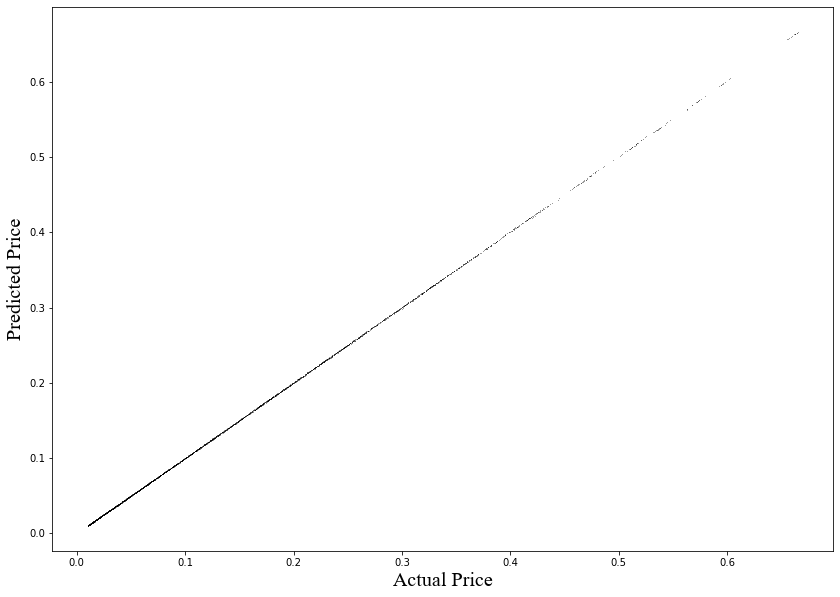

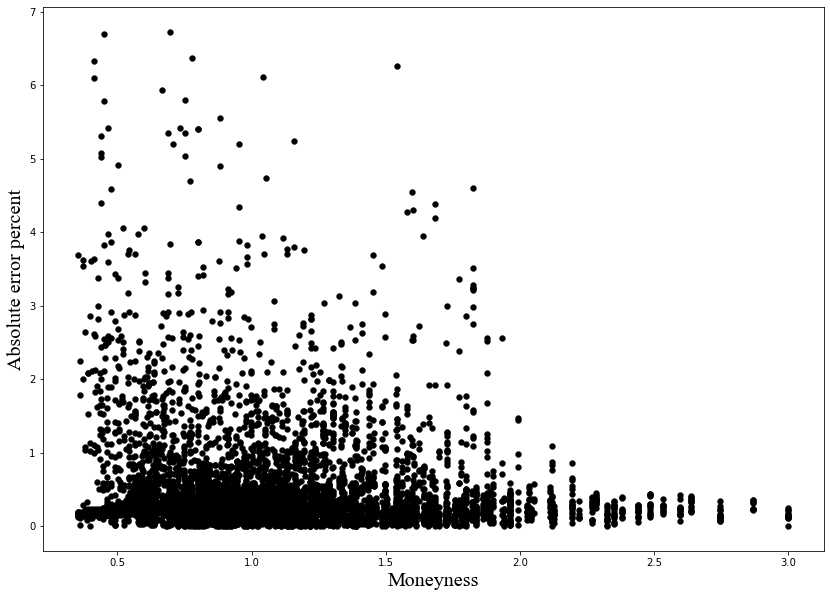

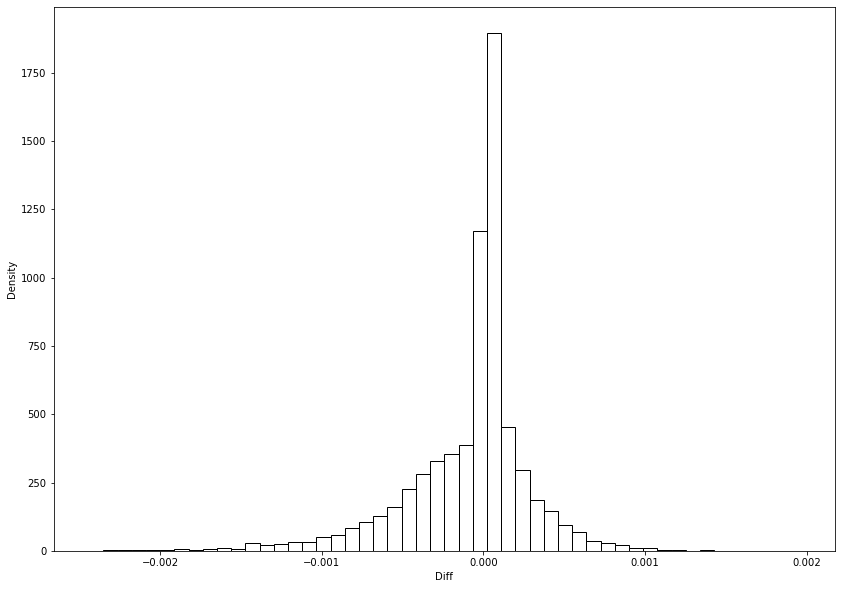

{'diff': array([ 1.17290765e-04,  1.32042915e-05,  1.86868012e-04, ...,
        -3.19484621e-04,  5.06356359e-04,  2.32551247e-05], dtype=float32),
 'Error percent': array([0.54602104, 0.13204291, 0.5915611 , ..., 0.5508237 , 0.38986135,
        0.23255125], dtype=float32),
 'mse': 1.5146472e-07,
 'rmse': 0.0003891847,
 'mae': 0.00024125224,
 'mpe': 0.004406588}

In [58]:
y_test_hat = model(x_test)
y_test_hat = np.squeeze(y_test_hat)
check_accuracy(y_test.numpy(), y_test_hat.detach().numpy(), x_test.numpy()[:,1]/x_test.numpy()[:,0])

#### Price accuracy with 5 layers model ( case 2: static sample)

In [69]:
def static_test(n=5000, dimension='S', low_bound=0.5, up_bound=1.5):
    static_test_df=generate_test_data(n=n, dimension=dimension, low_bound=low_bound, up_bound=up_bound)
    static_test_df['Put'] = np.where(static_test_df['Put'] < 0.01, 0.01, static_test_df['Put'])
    y_s_test = static_test_df['Put']
    x_s_test = static_test_df.drop(['Put','Vega'], 1)
    x_s_test=torch.tensor(x_s_test.values,dtype=torch.float)
    y_s_test=torch.tensor(y_s_test.values,dtype=torch.float)
    y_s_hat = model(x_s_test)
    y_s_hat = np.squeeze(y_s_hat)
    check_accuracy(y_s_test.numpy(), y_s_hat.detach().numpy(), x_s_test.numpy()[:,1]/x_s_test.numpy()[:,0])

Mean Squared Error:       5.446551e-06
Root Mean Squared Error:  0.0023337847
Mean Absolute Error:      0.00095927255
Mean Percent Error:       0.016619531


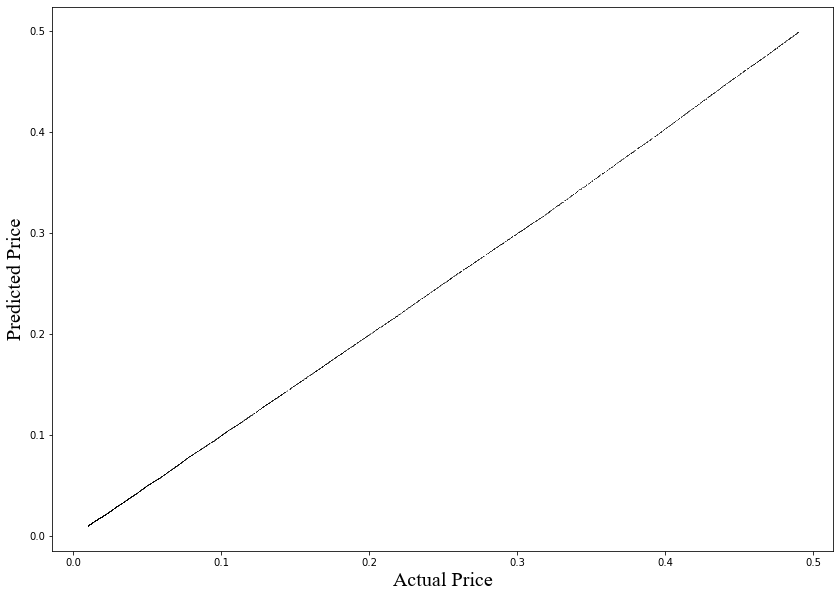

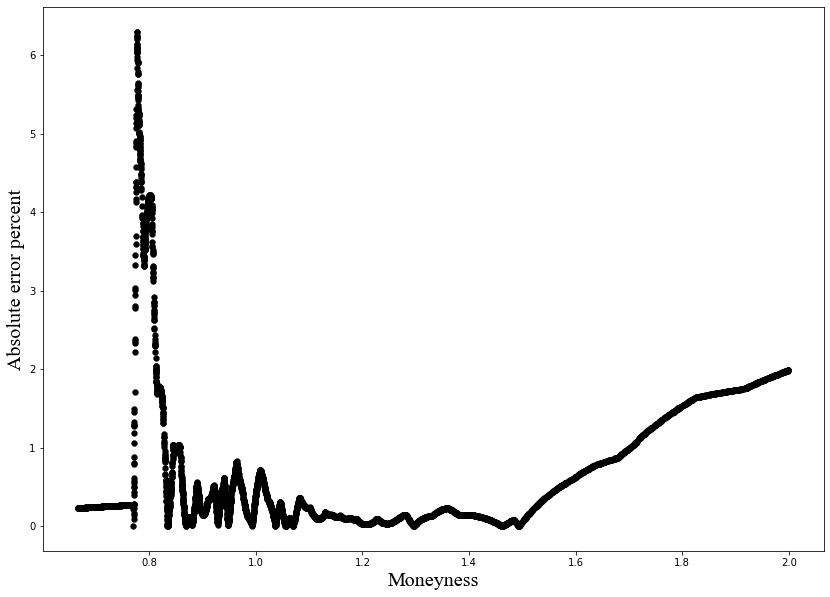

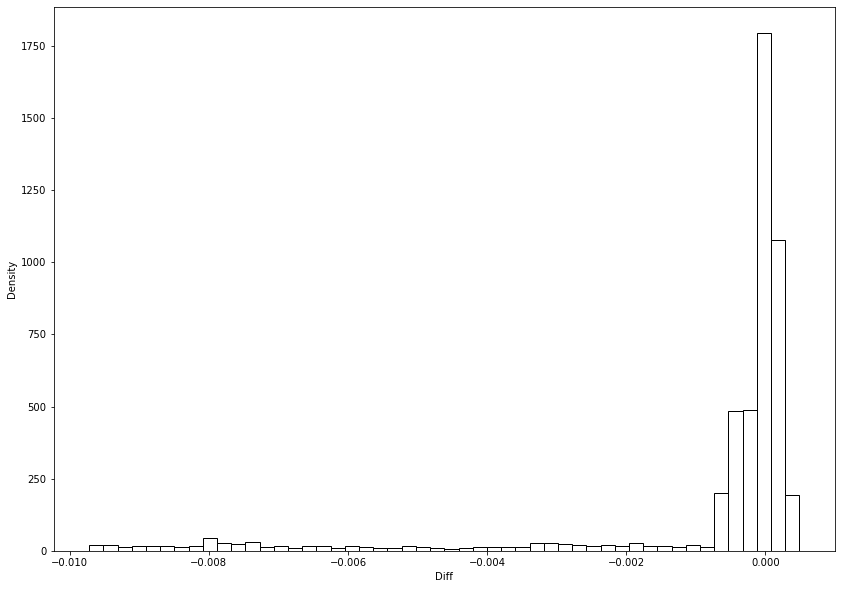

In [70]:
static_test(n=5000, dimension='S', low_bound=0.5, up_bound=1.5)

Mean Squared Error:       5.567664e-08
Root Mean Squared Error:  0.00023595899
Mean Absolute Error:      0.0001938373
Mean Percent Error:       0.003356687


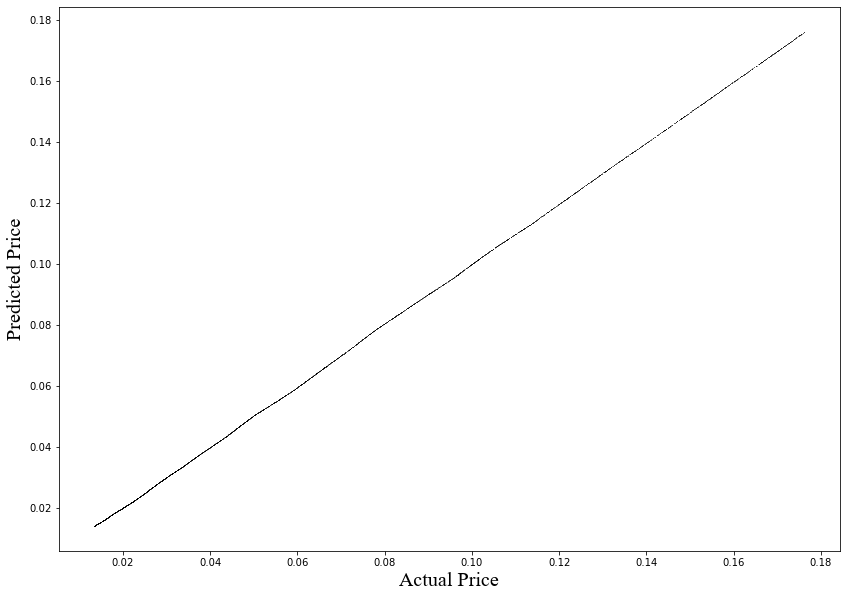

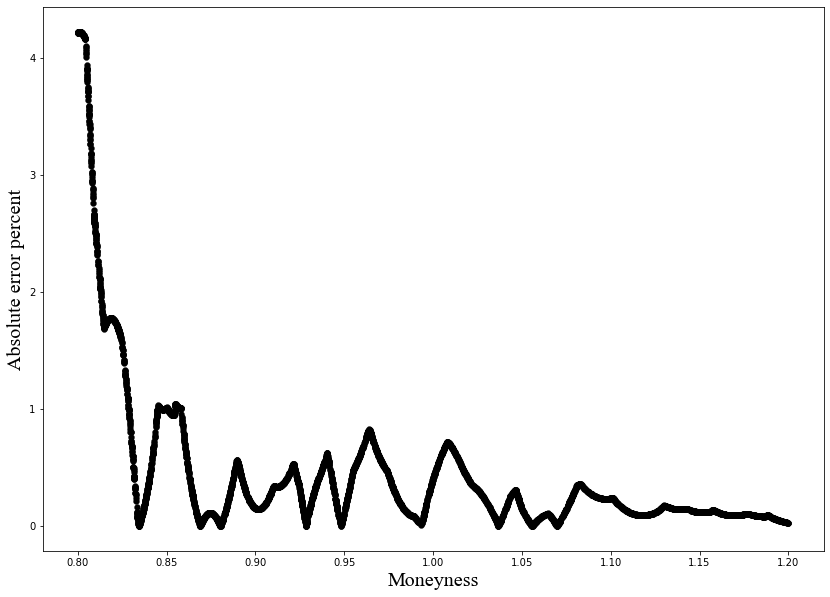

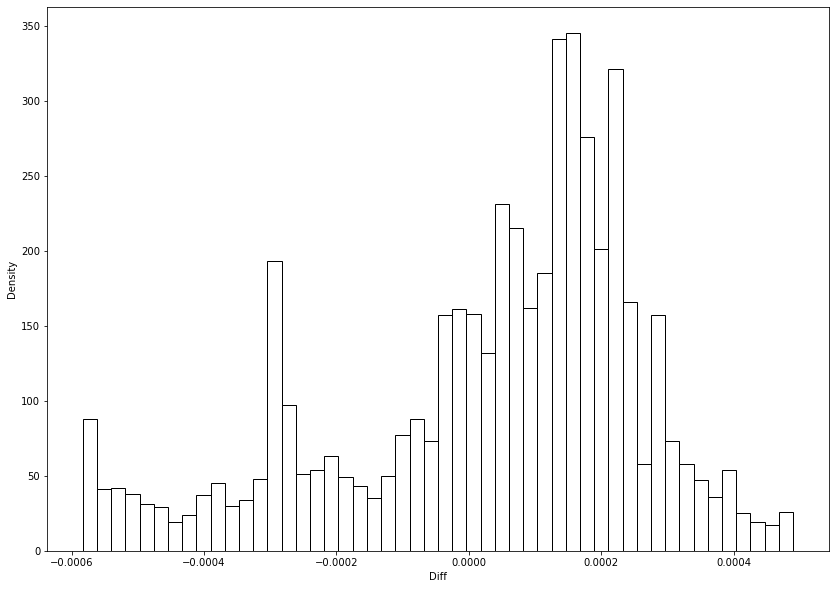

In [72]:
static_test(n=5000, dimension='S', low_bound=1/0.8, up_bound=1/1.2)

#### With static sample, the percentage errors get smaller compared to random sample. The result will vary a little bit with our different spot price ranges

## Phase 2: Reload price model and add more layers for smooth Greeks 

#### In phase 2, we add a 5 layers NN model to the pre-saved and well trained pricing model, the only output here is  $\Delta_S$

In [9]:
torch.save(model.state_dict(),'model_pre')

### Part 1 : New module design

In [10]:
model_transfer = torch.nn.Sequential(
        torch.nn.Linear(5,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,16),    
        torch.nn.CELU(),
        torch.nn.Linear(16,1))
model_transfer.load_state_dict(torch.load('model_pre'))
model_transfer.eval()

Sequential(
  (0): Linear(in_features=5, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=16, bias=True)
  (7): CELU(alpha=1.0)
  (8): Linear(in_features=16, out_features=1, bias=True)
)

In [11]:
for param in model_transfer.parameters():
    param.require_grad = False

### Part 2: Define a new module and add to the pre-trained model

In [12]:
fc = torch.nn.Sequential(
    torch.nn.Linear(1, 128),
    torch.nn.ReLU(),    
    torch.nn.Linear(128,16),
    torch.nn.CELU(),
    torch.nn.Linear(16,1))

In [13]:
model_transfer.add_module('fc',fc)

In [14]:
list(model_transfer.children())

[Linear(in_features=5, out_features=128, bias=True),
 ReLU(),
 Linear(in_features=128, out_features=1024, bias=True),
 ReLU(),
 Linear(in_features=1024, out_features=128, bias=True),
 ReLU(),
 Linear(in_features=128, out_features=16, bias=True),
 CELU(alpha=1.0),
 Linear(in_features=16, out_features=1, bias=True),
 Sequential(
   (0): Linear(in_features=1, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=16, bias=True)
   (3): CELU(alpha=1.0)
   (4): Linear(in_features=16, out_features=1, bias=True)
 )]

#### In our first model, we have 5 input features, in our second model, only the output( estimated put price) from the first model will be treat as the input.

### Part 3:  model_transfer training

In [16]:
df_train2 = generate_test_data(100000, 'S', 0.5, 2)
df_train2[["Delta","Gamma",'Theta']]=df_train2.apply(closedform_greeks, axis=1, result_type="expand")
df_test= generate_test_data(10000, 'S', 0.5, 2)
df_test[["Delta","Gamma",'Theta']]=df_test.apply(closedform_greeks, axis=1, result_type="expand")
# df_train2['Delta'] = np.where(df_train2['Put'] < 0.01, 0, df_train2['Delta'])
# df_test['Delta'] = np.where(df_test['Put'] < 0.01, 0, df_test['Delta'])
y2 = df_train2['Delta']
x2 = df_train2[['S','K','Vol','T','rf']]
y_test = df_test['Delta']
x_test = df_test[['S','K','Vol','T','rf']]
#x_train2,x_test2,y_train2,y_test2=model_selection.train_test_split(x2,y2,test_size=0)
# before using tensordataset, data must be converted to tensor
x_train2=torch.tensor(x2.values,dtype=torch.float)
x_test=torch.tensor(x_test.values,dtype=torch.float)
y_train2=torch.tensor(y2.values,dtype=torch.float)
y_test=torch.tensor(y_test.values,dtype=torch.float)

In [17]:
optimizer=optim.Adam(model_transfer.parameters(), lr=0.001)
n_epochs = 80
batch_size = 64

train_dataset2 = torch.utils.data.TensorDataset(x_train2, y_train2.view(-1, 1))
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, 
                                           batch_size=batch_size, 
                                           shuffle=True)
for epoch in range(n_epochs):
    for i, (features, delta) in enumerate(train_loader2):
        optimizer.zero_grad()
        output = model_transfer(features.float())
        loss = torch.nn.functional.mse_loss(output,delta)
        loss.backward()
        optimizer.step()

### Part 4: Model_transfer  estimated $\Delta_s$ performance evaluation

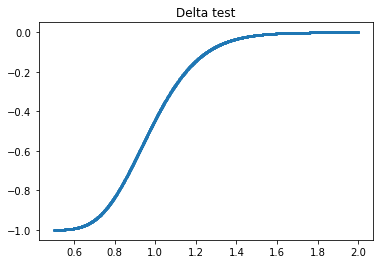

In [18]:
plt.scatter(df_test['S'],y_test,s=1)
plt.title('Delta test')
plt.show()

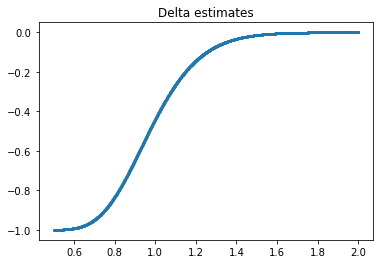

In [19]:
y_hat=model_transfer(x_test)
plt.scatter(df_test['S'],y_hat.detach().numpy(),s=1)
plt.title('Delta estimates')
plt.show()

#### We can tell from the two above plots, our estimates for $\Delta_S$ are very smooth, their numbers are printed below:

In [20]:
y_test

tensor([-1.2112e-01, -9.9855e-01, -7.4932e-01,  ..., -3.5740e-02,
        -1.7452e-01, -3.6006e-04])

In [21]:
y_hat

tensor([[-1.2069e-01],
        [-9.9848e-01],
        [-7.4969e-01],
        ...,
        [-3.5183e-02],
        [-1.7392e-01],
        [ 1.0383e-04]], grad_fn=<AddmmBackward>)

#### Now let's see how the absolute values and percentage errors perform

Mean Squared Error:       2.39951e-07
Root Mean Squared Error:  0.0004898479
Mean Absolute Error:      0.00041730786
Mean Percent Error:       -0.00152695


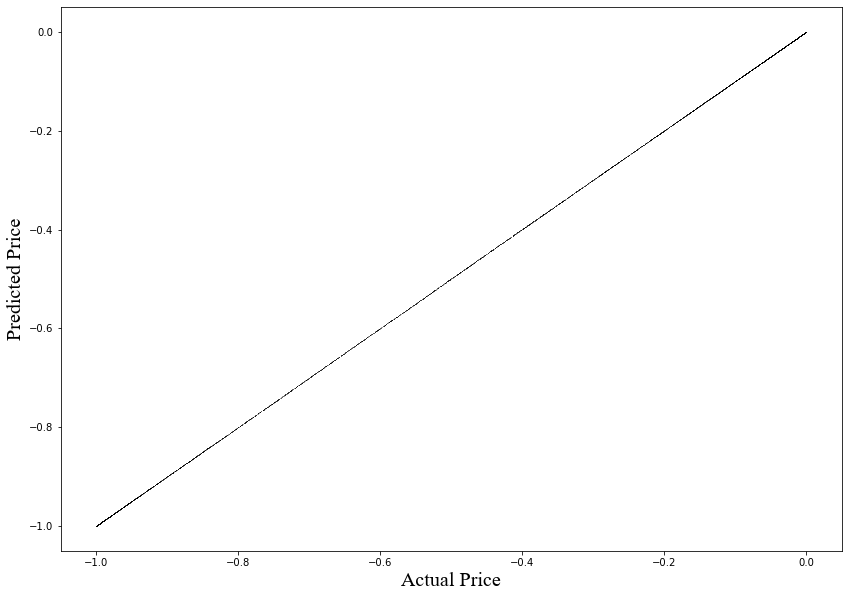

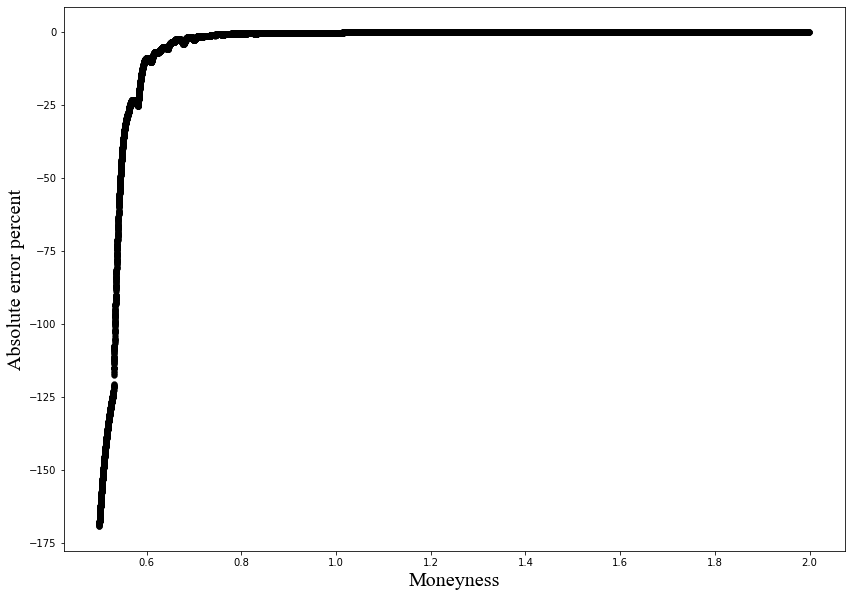

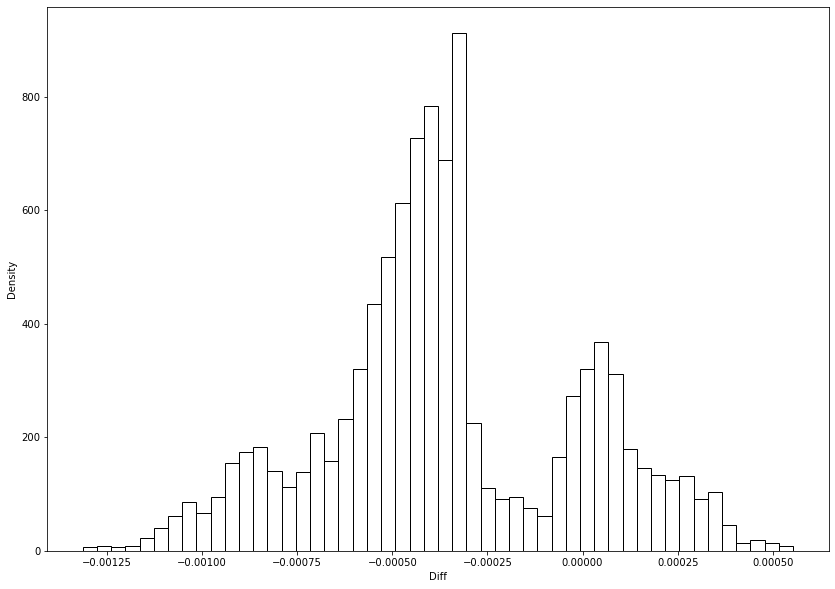

{'diff': array([-4.3113530e-04, -7.3730946e-05,  3.6793947e-04, ...,
        -5.5667758e-04, -5.9720874e-04, -4.6389474e-04], dtype=float32),
 'Error percent': array([-3.5595855e-01, -7.3837792e-03, -4.9103204e-02, ...,
        -1.5575743e+00, -3.4219930e-01, -1.2883694e+02], dtype=float32),
 'mse': 2.39951e-07,
 'rmse': 0.0004898479,
 'mae': 0.00041730786,
 'mpe': -0.00152695}

In [22]:
y_test_hat = model_transfer(x_test)
y_test_hat = np.squeeze(y_test_hat)
check_accuracy(y_test.numpy(), y_test_hat.detach().numpy(), x_test.numpy()[:,1]/x_test.numpy()[:,0])

#### The overall results are very satisfying, with MSE $2.39951e-07$, and RMSE $0.0004898479$. Most of the percentage errors are close to 0 though they become as large as  $175 \%$ when the option is deep out of money.

### Part 5: Computing $\Gamma_{SS}$ numerically from estimated $\Delta_S$, Or multi_outputs with combined loss funtions?

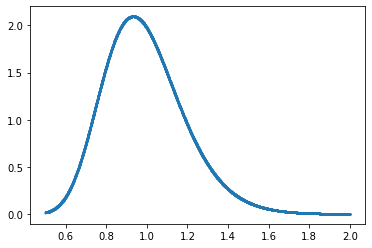

In [23]:
# Closed form Gamma
plt.scatter(df_test['S'],df_test['Gamma'],s=1)
plt.show()

In [24]:
df_test['Delta_hat']=y_hat.detach().numpy()
df_test=df_test.sort_values(by='S',ascending=True)
df_test['Gamma_hat']=df_test['Delta_hat'].diff()/df_test['S'].diff()

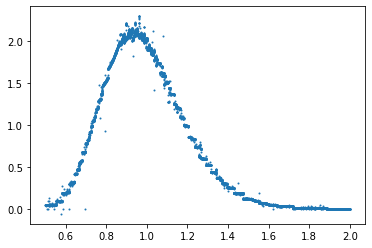

In [25]:
# Numerical Gamma
df_test2=df_test.copy()
plt.scatter(df_test['S'][:-1],df_test['Gamma_hat'][1:],s=1)
plt.show()

#### Hmmm, not too bad using numerical calculation, but lots of uncontinuity and bumps, need to be smoothed. Partial results are shown below:

In [26]:
df_test[(df_test['S']<=1.0)& (df_test['S']>=0.99)]

,S,K,Vol,T,rf,Put,Vega,Delta,Gamma,Theta,Delta_hat,Gamma_hat
6310,0.990149,1.0,0.2,1.0,0.01,0.078817,0.393022,-0.459973,2.004408,-0.033960,-0.458911,1.999290
6785,0.990153,1.0,0.2,1.0,0.01,0.078816,0.393023,-0.459965,2.004396,-0.033960,-0.458903,1.984769
4836,0.990285,1.0,0.2,1.0,0.01,0.078755,0.393049,-0.459702,2.003996,-0.033965,-0.458640,2.000693
9757,0.990553,1.0,0.2,1.0,0.01,0.078632,0.393101,-0.459165,2.003178,-0.033976,-0.458103,2.001421
3441,0.990765,1.0,0.2,1.0,0.01,0.078535,0.393142,-0.458739,2.002527,-0.033984,-0.457678,2.003783
...,...,...,...,...,...,...,...,...,...,...,...,...
8033,0.999463,1.0,0.2,1.0,0.01,0.074620,0.394425,-0.441441,1.974243,-0.034284,-0.440281,2.013545
1976,0.999569,1.0,0.2,1.0,0.01,0.074573,0.394436,-0.441233,1.973882,-0.034287,-0.440069,2.017533
5040,0.999633,1.0,0.2,1.0,0.01,0.074545,0.394442,-0.441106,1.973660,-0.034289,-0.439939,2.015794
6456,0.999742,1.0,0.2,1.0,0.01,0.074497,0.394454,-0.440892,1.973287,-0.034293,-0.439719,2.018993


#### What if we do multi output prediction? sum two loss functions of Delta and Gamma

In [27]:
torch.save(model_transfer.state_dict(),'model_delta_transfer')

In [28]:
model_transfer2 = torch.nn.Sequential(
        torch.nn.Linear(5,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,16),    
        torch.nn.CELU(),
        torch.nn.Linear(16,1))
model_transfer2.load_state_dict(torch.load('model_pre'))
model_transfer2.eval()

for param in model_transfer2.parameters():
    param.require_grad = False
    
fc = torch.nn.Sequential(
    torch.nn.Linear(1, 128),
    torch.nn.ReLU(),    
    torch.nn.Linear(128,16),
    torch.nn.CELU(),
    torch.nn.Linear(16,2))  # same architecture, two outputs 

model_transfer2.add_module('fc',fc)

list(model_transfer2.children())

[Linear(in_features=5, out_features=128, bias=True),
 ReLU(),
 Linear(in_features=128, out_features=1024, bias=True),
 ReLU(),
 Linear(in_features=1024, out_features=128, bias=True),
 ReLU(),
 Linear(in_features=128, out_features=16, bias=True),
 CELU(alpha=1.0),
 Linear(in_features=16, out_features=1, bias=True),
 Sequential(
   (0): Linear(in_features=1, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=16, bias=True)
   (3): CELU(alpha=1.0)
   (4): Linear(in_features=16, out_features=2, bias=True)
 )]

In [29]:
df_train2 = generate_test_data(100000, 'S', 0.5, 2)
df_train2=df_train2.sort_values(by='S')
df_train2[["Delta","Gamma",'Theta']]=df_train2.apply(closedform_greeks, axis=1, result_type="expand")
df_test= generate_test_data(10000, 'S', 0.5, 2)
df_test[["Delta","Gamma",'Theta']]=df_test.apply(closedform_greeks, axis=1, result_type="expand")
# df_train2['Delta'] = np.where(df_train2['Put'] < 0.01, 0, df_train2['Delta'])
# df_test['Delta'] = np.where(df_test['Put'] < 0.01, 0, df_test['Delta'])
y2 = df_train2[['Delta','Gamma']]
x2 = df_train2[['S','K','Vol','T','rf']]
y_test = df_test[['Delta','Gamma']]
x_test = df_test[['S','K','Vol','T','rf']]
#x_train2,x_test2,y_train2,y_test2=model_selection.train_test_split(x2,y2,test_size=0)
# before using tensordataset, data must be converted to tensor
x_train2=torch.tensor(x2.values,dtype=torch.float)
x_test=torch.tensor(x_test.values,dtype=torch.float)
y_train2=torch.tensor(y2.values,dtype=torch.float)
y_test=torch.tensor(y_test.values,dtype=torch.float)

In [30]:
optimizer=optim.Adam(model_transfer2.parameters(), lr=0.001)
n_epochs = 80
batch_size = 64

train_dataset2 = torch.utils.data.TensorDataset(x_train2, y_train2[:,0],y_train2[:,1])
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, 
                                           batch_size=batch_size, 
                                           shuffle=True)
for epoch in range(n_epochs):
    for i, (features, delta,gamma) in enumerate(train_loader2):
        optimizer.zero_grad()
        output = model_transfer2(features.float())
        loss = torch.nn.functional.mse_loss(output[:,0],delta)+torch.nn.functional.mse_loss(output[:,1],gamma)
        loss.backward()
        optimizer.step()

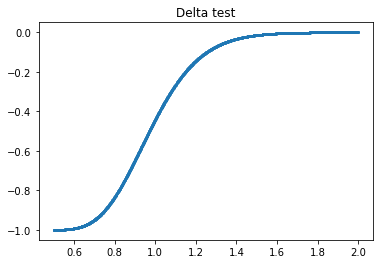

In [31]:
plt.scatter(df_test['S'],y_test[:,0],s=1)
plt.title('Delta test')
plt.show()

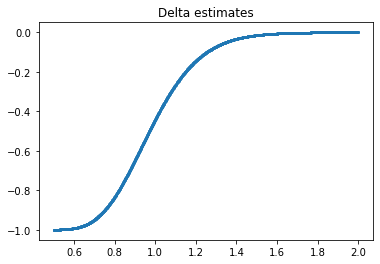

In [32]:
y_hat=model_transfer2(x_test)
plt.scatter(df_test['S'],y_hat[:,0].detach().numpy(),s=1)
plt.title('Delta estimates')
plt.show()

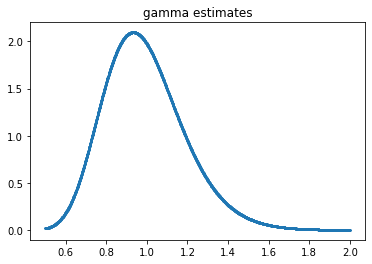

In [33]:
plt.scatter(df_test['S'],y_hat[:,1].detach().numpy(),s=1)
plt.title('gamma estimates')
plt.show()

#### We have great results!! Seems that implementing multi-outputs worked here.

#### What if we keep using single output, but repeat the process we did for smoothing $\Delta_S$, we add the 'third' model to deal with the bumps in $\Gamma_{SS}$

#### The third model was designd as the same with the second one

In [34]:
for param in model_transfer.parameters():
    param.require_grad = False
    
fc1 = torch.nn.Sequential(
    torch.nn.Linear(1, 128),
    torch.nn.ReLU(),    
    torch.nn.Linear(128,16),
    torch.nn.CELU(),
    torch.nn.Linear(16,1))  # same architecture, two outputs 

model_transfer.add_module('fc1',fc1)

list(model_transfer.children())

[Linear(in_features=5, out_features=128, bias=True),
 ReLU(),
 Linear(in_features=128, out_features=1024, bias=True),
 ReLU(),
 Linear(in_features=1024, out_features=128, bias=True),
 ReLU(),
 Linear(in_features=128, out_features=16, bias=True),
 CELU(alpha=1.0),
 Linear(in_features=16, out_features=1, bias=True),
 Sequential(
   (0): Linear(in_features=1, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=16, bias=True)
   (3): CELU(alpha=1.0)
   (4): Linear(in_features=16, out_features=1, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=1, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=16, bias=True)
   (3): CELU(alpha=1.0)
   (4): Linear(in_features=16, out_features=1, bias=True)
 )]

#### Same training process, excepct that this time, the first two models' parameters were frozon, and the only input for the third model is estimated $\Delta_S$ from the second model output!

In [35]:
df_train2 = generate_test_data(100000, 'S', 0.5, 2)
df_train2=df_train2.sort_values(by='S')
df_train2[["Delta","Gamma",'Theta']]=df_train2.apply(closedform_greeks, axis=1, result_type="expand")
df_test= generate_test_data(10000, 'S', 0.5, 2)
df_test[["Delta","Gamma",'Theta']]=df_test.apply(closedform_greeks, axis=1, result_type="expand")
# df_train2['Delta'] = np.where(df_train2['Put'] < 0.01, 0, df_train2['Delta'])
# df_test['Delta'] = np.where(df_test['Put'] < 0.01, 0, df_test['Delta'])
y2 = df_train2['Gamma']
x2 = df_train2[['S','K','Vol','T','rf']]
y_test = df_test['Gamma']
x_test = df_test[['S','K','Vol','T','rf']]
#x_train2,x_test2,y_train2,y_test2=model_selection.train_test_split(x2,y2,test_size=0)
# before using tensordataset, data must be converted to tensor
x_train2=torch.tensor(x2.values,dtype=torch.float)
x_test=torch.tensor(x_test.values,dtype=torch.float)
y_train2=torch.tensor(y2.values,dtype=torch.float)
y_test=torch.tensor(y_test.values,dtype=torch.float)

In [36]:
optimizer=optim.Adam(model_transfer.parameters(), lr=0.001)
n_epochs = 80
batch_size = 64

train_dataset2 = torch.utils.data.TensorDataset(x_train2, y_train2.view(-1, 1))
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, 
                                           batch_size=batch_size, 
                                           shuffle=True)
for epoch in range(n_epochs):
    for i, (features, gamma) in enumerate(train_loader2):
        optimizer.zero_grad()
        output = model_transfer(features.float())
        loss = torch.nn.functional.mse_loss(output,gamma)
        loss.backward()
        optimizer.step()

#### Gamma evaluation

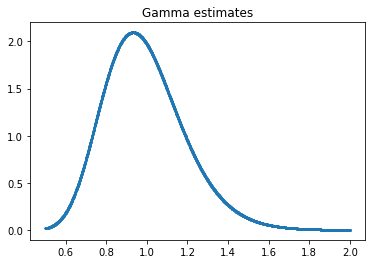

In [37]:
y_hat=model_transfer(x_test)
plt.scatter(df_test['S'],y_hat.detach().numpy(),s=1)
plt.title('Gamma estimates')
plt.show()

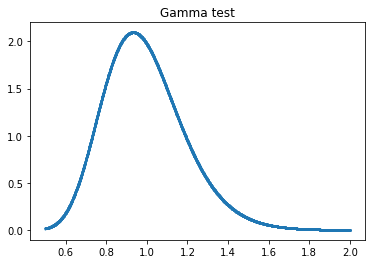

In [38]:
plt.scatter(df_test['S'],y_test,s=1)
plt.title('Gamma test')
plt.show()

#### We have very smooth results as expected

Mean Squared Error:       2.145204e-06
Root Mean Squared Error:  0.0014646515
Mean Absolute Error:      0.0009675483
Mean Percent Error:       0.0022009108


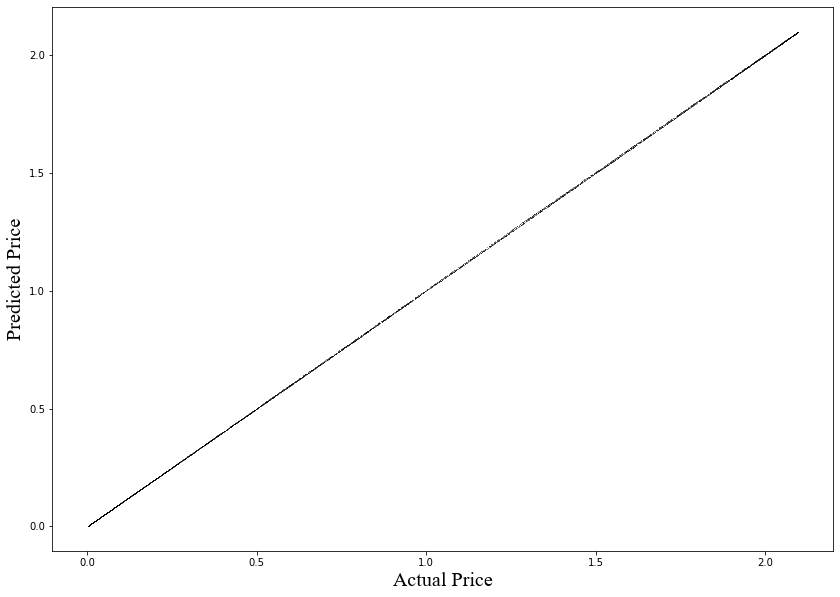

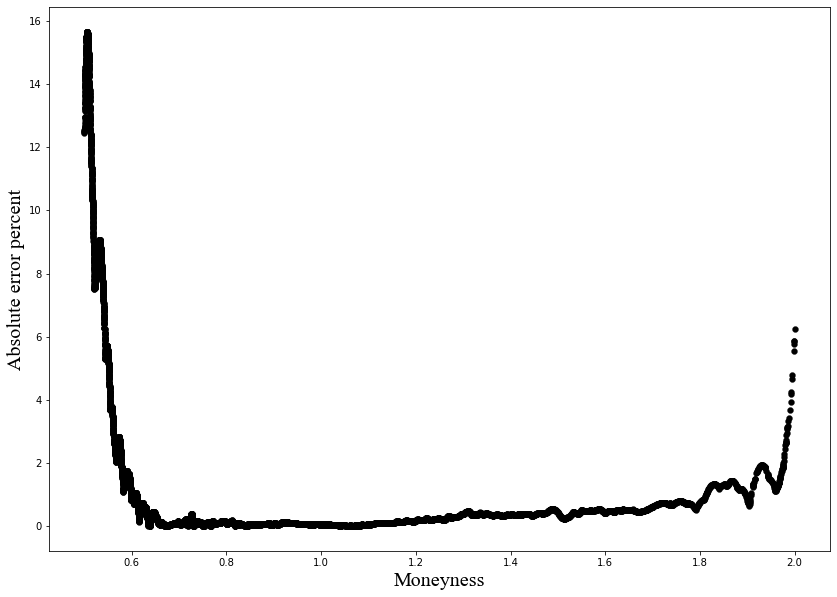

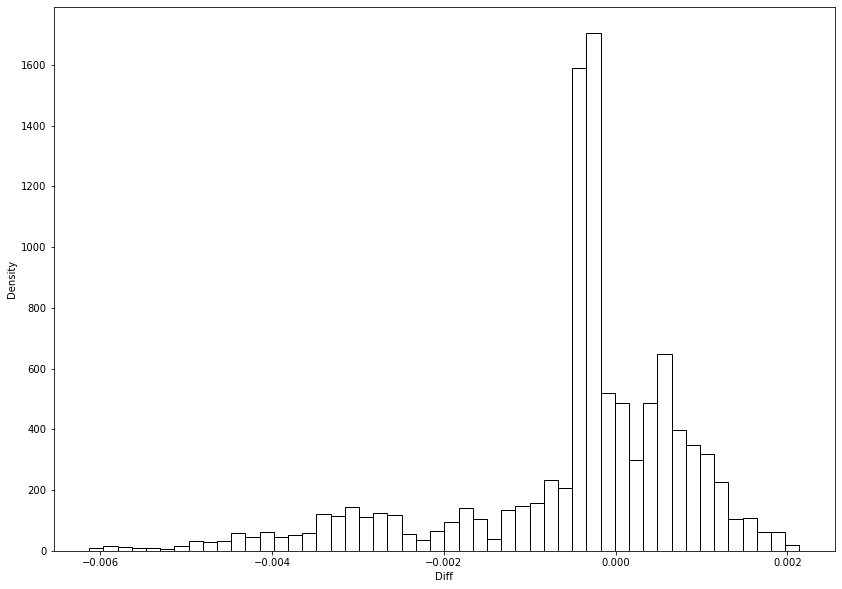

{'diff': array([-0.00078964, -0.00393796, -0.00328565, ...,  0.00184548,
        -0.0003307 , -0.0002919 ], dtype=float32),
 'Error percent': array([0.03772105, 0.27863967, 0.1898582 , ..., 0.11819303, 2.4440606 ,
        8.255382  ], dtype=float32),
 'mse': 2.145204e-06,
 'rmse': 0.0014646515,
 'mae': 0.0009675483,
 'mpe': 0.0022009108}

In [39]:
y_test_hat = np.squeeze(y_hat)
check_accuracy(y_test.numpy(), y_test_hat.detach().numpy(), x_test.numpy()[:,1]/x_test.numpy()[:,0])

#### Now the MSE get a bit larger compared to our $\Delta_S$ results, and for both deep ITM and OTM areas, the percentage error get larger, but much smaller compared to $175\%$ for $\Delta_S$. The overall performance is still good.